# Predicting Category of an incident based on the information provided by the customer

### In this notebook, I am testing out to see if a basic classifier can do the job of classifying incidents reported to the campus computing department of UT Tyler 

#### Importing all the needed libraries

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

#### Importing the data that is in cvs format

In [21]:
email_df = pd.read_csv("emails.csv", encoding='latin1')

#### Looking at the data

In [22]:
email_df.head()

,Subject,Body,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),CC: (Type),BCC: (Name),BCC: (Address),BCC: (Type),Billing Information,Categories,Importance,Mileage,Sensitivity
0,Your incident INC0121272 has been closed,Your incident INC0121272 has been closed. If y...,IT Support,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,Ashim Sedhain,/o=UTTyler Organization/ou=Exchange Administra...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
1,Preview of the May Agenda,Good morning! We would like to invite you to o...,Lynette Sutter,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...,Beth Bruce,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...,usac,/O=UTTYLER ORGANIZATION/OU=EXCHANGE ADMINISTRA...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal


#### We can see that we get alot of data from the email. We will only use the subject and body of the email for the classification

#### Dropping columns all the columns besides the "Subject", and "Body".

In [23]:
email_df = email_df[["Subject", "Body"]]

#### Getting another look at the data now

In [24]:
email_df.head()

,Subject,Body
0,Your incident INC0121272 has been closed,Your incident INC0121272 has been closed. If y...
1,Preview of the May Agenda,Good morning! We would like to invite you to o...
2,CEP Dean Candidate Campus Wide Presentation/Go...,Please use the link below to access the Zoom r...
3,CEP Dean Candidate Campus Wide Presentation/Ro...,Please use the link below to access the Zoom r...
4,University Appreciation Week - A Few Reminders,Hello everyone!\r\n\r\n \r\n\r\nPlease see the...


# Cleaning the data 

#### Getting a closer look at the Body column

In [25]:
email_df.iloc[5, 1]

'You have been invited to take the survey: CCS Customer Satisfaction Survey. \r\n \r\nClick here to take your survey:\r\nhttps://uttyler.service-now.com/nav_to.do?uri=assessment_take2.do%3Fsysparm_assessable_type=4a9b211f2b0af10081807fb5a8da15d4%26sysparm_assessable_sysid=1afc56f5db5d73c8879ac3d239961920\r\n \r\nTo view your survey queue at any time, sign in and navigate to Self-Service > My Assessments & Surveys.\r\n \r\nRef:MSG1817995\r\n'

#### We can see the body has a lot of data which needs to be cleaned and parsed.

#### Whenever a ticket is submitted, the ticket contains the information about the person who submitted the ticket, subject and body. We will extract the category, which we are trying to predict, the body, and the subject.

#### Extracting the category from the Body text

In [26]:
email_df["Category"]= email_df["Body"].str.extract(r"Category: (\w+ ?\w+)\r")

#### Extracting Short Descriptions from the Body

In [27]:
email_df["Short Description"] = email_df["Body"].str.extract(r"Short Description: (.+)\r")

#### Extracting Additional comments from the Body text

In [28]:
email_df["Additional Comments"] = email_df["Body"].str.extract(r"Additional comments\r\nreceived from:(.+)Ref", flags = re.DOTALL)

#### Removing all the rows that do not have a Category and Short Description as these are emails that did not contain ticket related information

In [29]:
email_df.dropna(subset = ["Category", "Short Description"], inplace = True)

#### We will look at the shape to count the number of observation.

In [30]:
email_df.shape

(4334, 5)

#### We will look at the our dataframe.

In [31]:
email_df[["Short Description", "Category", "Additional Comments"]].head()

,Short Description,Category,Additional Comments
6,Ashim Sedhain - credential pick up,Account,NaN
41,Engineering office moves,Hardware,"KatrinaSmith@uttyler.edu\r\n \r\nMichael, \r..."
42,EVGA UV Plus - Multi-Screen expansion,Quotes,rpeterson@uttyler.edu\r\n \r\nBefore I purcha...
44,Printers,Hardware,sbouis@uttyler.edu\r\n \r\nPlease help us dis...
45,Event Reservation #20190522-00016: Resource St...,Classroom Technology,Astraemail@uttyler.edu\r\n \r\n \r\n


In [32]:
email_df["Additional Comments"].head()

6                                                   NaN
41     KatrinaSmith@uttyler.edu\r\n \r\nMichael,  \r...
42     rpeterson@uttyler.edu\r\n \r\nBefore I purcha...
44     sbouis@uttyler.edu\r\n \r\nPlease help us dis...
45                 Astraemail@uttyler.edu\r\n \r\n \r\n
Name: Additional Comments, dtype: object

#### We can see that the Additional Comments needs to be further cleaned.

#### We will replace all the new line characters.

In [33]:
email_df["Additional Comments mod"] = email_df["Additional Comments"].str.replace(r"\r|\n", "", regex = True)

In [34]:
email_df["Additional Comments mod"] = email_df["Additional Comments mod"].str.replace(r"\w+@\w+\.(edu)|(com)", "")

In [35]:
email_df["Additional Comments mod"].head()

6                                                   NaN
41      Michael,   WE have some faculty moving offic...
42      Before I purchase a new EVGA UV Plus device ...
44      Please help us disconnect all desktop printe...
45                                                     
Name: Additional Comments mod, dtype: object

#### Let's look at specific category and see their contents. 

In [36]:
gk = email_df.groupby("Category")

In [37]:
gk.first()

,Subject,Body,Short Description,Additional Comments,Additional Comments mod
Category,,,,,
Account,Your incident INC0121272 has been resolved due...,Due to no customer response your incident INC0...,Ashim Sedhain - credential pick up,\r\n \r\nYes hi I don't expect it into each e...,Yes hi I don't expect it into each each holl...
Classroom Technology,Incident INC0122885 has been assigned to group...,Short Description: Event Reservation #20190522...,Event Reservation #20190522-00016: Resource St...,Astraemail@uttyler.edu\r\n \r\n \r\n,
Delete,Incident INC0122931 has been assigned to group...,Short Description: Congratulations : Assignmen...,Congratulations : Assignment Writing Service f...,"shalu.rani@aol.com\r\n \r\nDear Students,\r\n...","shalu.rani@aol. Dear Students, Yourchance o..."
Hardware,Incident INC0122904 has been assigned to group...,Short Description: Engineering office moves\r\...,Engineering office moves,"KatrinaSmith@uttyler.edu\r\n \r\nMichael, \r...","Michael, WE have some faculty moving offic..."
None,Incident INC0125169 has been assigned to group...,Short Description: Dakota-Request to borrow a ...,Dakota-Request to borrow a monitor temporarily,NaN,NaN
Questions,Incident INC0127614 has been assigned to group...,Short Description: Jooble partnership outlook....,Jooble partnership outlook.uttyler.edu,"rma@jooble.jobs\r\n \r\nHello,\r\n \r\nHope y...","rma@jooble.jobs Hello, Hope you are doing wel..."
Quotes,Incident INC0122638 has been assigned to group...,Short Description: EVGA UV Plus - Multi-Screen...,EVGA UV Plus - Multi-Screen expansion,rpeterson@uttyler.edu\r\n \r\nBefore I purcha...,Before I purchase a new EVGA UV Plus device ...
Software,Incident INC0122883 has been assigned to group...,Short Description: Adobe Flash Player installa...,Adobe Flash Player installation,"TArtley@uttyler.edu\r\n \r\nGood Afternoon, \...","Good Afternoon, I need to have adobe flash ..."
Telecomm,Incident INC0129425 has been assigned to group...,Short Description: OTS Alert - Ticket ID: 1232...,OTS Alert - Ticket ID: 1232 - Houston to Lake ...,no-reply@ots.utsystem.edu\r\n \r\nUnfortunate...,"no-reply@ots.utsystem.edu Unfortunately, noth..."


#### We will concatenate the Short Description and Additional Comments field to get the Feature which will be used for the final classification.

In [38]:
email_df["Feature"] = email_df["Short Description"].str.cat(email_df["Additional Comments mod"], sep = ' ')

In [39]:
email_df["Feature"].fillna(value = email_df["Short Description"], inplace = True)

#### A side note: There are dublicate tickets which will not be present in the final production and thus need to be removed from our sample

#### Extracting the incident number

In [40]:
email_df["Incident Number"] = email_df["Subject"].str.extract(r"INC(\d+) ")

In [41]:
print(f"Total number of unique emails: {email_df['Incident Number'].unique().size}")

Total number of unique emails: 3838


In [42]:
print(f"Total number of incidents: {email_df['Incident Number'].size}")

Total number of incidents: 4334


#### There seems to be dublicate incidents which need to be removed

## We will now look at our data and perfrom a simple data analysis

####  Lets look at the historgram of the lables

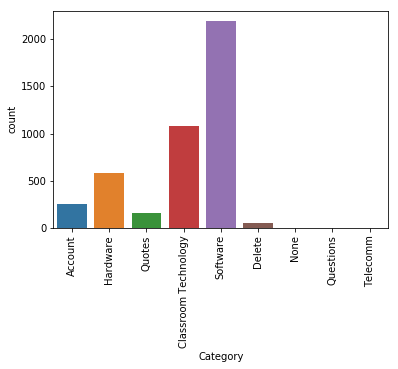

In [43]:
ax = sns.countplot("Category", data = email_df)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

#### Seeing the ratio of each class

In [44]:
email_df["Category"].value_counts()*100/email_df["Category"].size

Software                50.553761
Classroom Technology    25.034610
Hardware                13.359483
Account                  5.791417
Quotes                   3.691740
Delete                   1.315182
Questions                0.115367
None                     0.115367
Telecomm                 0.023073
Name: Category, dtype: float64

#### We can see that the categories are heavly imbalanced. We will need to account for the imbalance.

## Modeling

#### Converting the classes into numerical representation

In [45]:
dic = {i:j for i, j in zip(email_df["Category"].unique(), range(len(email_df["Category"].unique())))}

In [46]:
email_df["Targets"] = email_df["Category"].map(dic)

#### Looking at our data and seeing where we are.

In [47]:
email_df[["Feature", "Category","Targets"]].head()

,Feature,Category,Targets
6,Ashim Sedhain - credential pick up,Account,0
41,"Engineering office moves Michael, WE have ...",Hardware,1
42,EVGA UV Plus - Multi-Screen expansion Before...,Quotes,2
44,Printers Please help us disconnect all desk...,Hardware,1
45,Event Reservation #20190522-00016: Resource St...,Classroom Technology,3


#### We will only be using the Feature column for our classification.

In [48]:
X = email_df["Feature"]
y = email_df["Targets"]

#### Spliting the data for training and testing

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#### Fitting the CountVectorizer to the training data

In [50]:
# vect = CountVectorizer()
vect = TfidfVectorizer(ngram_range = (1, 1))

In [51]:
vect = vect.fit(x_train)

#### We can see how many features we have.

In [52]:
len(vect.get_feature_names())

13450

#### Transforming our training data into a sparse matrix

In [53]:
x_train_vec = vect.transform(x_train)

In [54]:
x_train_vec

<3250x13450 sparse matrix of type '<class 'numpy.float64'>'
	with 122829 stored elements in Compressed Sparse Row format>

## Classification

#### We will create multiple models and compare there performance.

#### Supervised Learning

In [55]:
logistic_clf = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 0)

In [56]:
naive_clf = MultinomialNB(alpha=0.001)

In [57]:
svm_clf = svm.SVC(gamma = 0.1, random_state = 0, kernel = "linear")

In [58]:
knn_clf = KNeighborsClassifier(n_neighbors=20)

In [59]:
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=5,random_state=0)

In [60]:
gb_clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, random_state = 0)

In [61]:
clf = [logistic_clf, naive_clf, svm_clf, knn_clf, rf_clf, gb_clf]

clf_dic = ["Logistic", "Naive", "SVM", "KNN", "RandomForest", "GradientBoosting"]

#### Fitting all the models

In [62]:
for i in clf:
    i.fit(x_train_vec, y_train)

#### Looking at the f1 score of each classifier

In [63]:
for i,j in zip(clf_dic, clf):
    print(f"{i}: {f1_score(j.predict(vect.transform(x_test)), y_test, average = 'micro')}")

Logistic: 0.827490774907749
Naive: 0.8035055350553506
SVM: 0.8330258302583026
KNN: 0.8025830258302583
RandomForest: 0.6291512915129152
GradientBoosting: 0.8136531365313654


#### We will look at the top features from each of the classifiers

In [64]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

In [65]:
show_top10(logistic_clf, vect, email_df["Category"].unique())

Account: pick change patriots name log pw password employee reset account
Hardware: device office lab monitor printers move print disposal computer printer
Quotes: specs adobe two dell pro acrobat order purchase for quote
Classroom Technology: ignore room call assist over tech send projector display missed
Software: onedrive windows desktop shared install outlook my imagenow access image
Delete: email ru m2bhko5pr1e4fki7zhx1nggkojpguezp9zsu bxgzu8 tibh trouble gmail login proofpoint delete
None: dept delivery macbook imac air pros mathematic probook 21020 030466
Questions: goal https security email student address cs info jooble roles
Telecomm: at jackson down utsystem 1232 lake galveston circuits ots houston


In [66]:
show_top10(naive_clf, vect, email_df["Category"].unique())

Account: myuttyler to password employee change name my account pw reset
Hardware: tyler university 903 in of and computer to the printer
Quotes: order to 903 and university tyler of the for quote
Classroom Technology: will laptop pc display to me send over assist tech
Software: for access is in my of and image the to
Delete: in of https and email for the proofpoint to delete
None: dept delivery macbook imac air pros mathematic probook 21020 030466
Questions: you https student email info address cs jooble the roles
Telecomm: jackson to down utsystem 1232 lake ots galveston circuits houston


In [69]:
show_top10(gb_clf, vect, email_df["Category"].unique())

AttributeError: 'GradientBoostingClassifier' object has no attribute 'coef_'

# Further Improvements

#### We can see some of the words that have been associated to different categories. The thing to notice in the Naive classifier is that, "for", "of", "it" and other stop words have been mapped to account category which will need to be removed. Furthermore, in the classroom technology category, "tech", "over", "send" have been mapped, which comes from the system bypassing the prediction process. So, those need to be removed as well. This can be happening with other categories and as such needs further cleanning.